In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import pandas as pd
import seaborn as sns
import pandas as pd
#from dataprep.eda import create_report
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import plotly.express as px
import pycountry
import altair as alt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [4]:
def read_data():
    '''
    Lê e constrói as base de dados da pesquisa 
    Mental Health in Tech Survey e os dados fornecidos pela OMS
    respectivamente
    '''
    df = pd.read_csv("survey.csv")
    # Who regions in Kaggle dataset
    who_dict = {
        "Bosnia and Herzegovina": "Bosnia And Herzegovina",
        "Bahamas, The": "Bahamas",
        "Moldova": "Republic Of Moldova",
        "United States": "United States Of America",
    }
    df = df.replace({"Country": who_dict})
    # Atlas Data
    df_atlas = pd.DataFrame(
        [
            ["AFRO", "AMRO", "EMRO", "EURO", "SEARO", "WPRO"],
            [0.32, 0.31, 0.38, 0.51, 0.45, 0.52],
        ]
    ).T
    df_atlas.columns = ["Region Name", "Functional Programs Rate"]
    df_regions = pd.read_csv("WHO Regions.csv")
    df = df.merge(df_regions, how="left", on="Country")
    df["Region Name"] = df["Region Name"].str.split(" ").str[0] + "O"
    df = df.merge(df_atlas, how="left", on="Region Name")
    df["Functional Programs Rate"] = df["Functional Programs Rate"].astype(float)
    df['Region Number'] = df['Region Number'].astype(str)
    return df

In [6]:
def process_data(df):
    '''
    Trata valores fora da realidade da pesquisa como faltantes,
    e corrige as repostas para gêneros. Essa função não faz nenhum
    tipo de inferência, para que não ocorra Data  Leakage'''
    # Age fix
    age_series = pd.Series(df["Age"])
    age_series[(age_series < 18) | (age_series > 90)] = np.nan
    df["Age"] = age_series

    # Country fix
    input_countries = df["Country"].unique().tolist()
    countries = {}
    for country in pycountry.countries:
        countries[country.name] = country.alpha_3
    df = df.replace({"Country": countries})

    # Gender fix
    df["Gender"] = df["Gender"].str.lower()
    df["Gender"] = df["Gender"].str.strip()
    gender_dict = {
        "femail": "female",
        "femake": "female",
        "f": "female",
        "m": "male",
        "male-ish": "male",
        "mal": "male",
        "malr": "male",
        "man": "male",
        "msle": "male",
        "make": "male",
        "mail": "male",
        "maile": "male",
        "male?": "male",
        "male (cis)": "male",
        "female (cis)": "female",
        "cis man": "male",
        "guy (-ish) ^_^": "male",
        "female (trans)": "trans",
        "male? ": "male",
        "woman": "female",
    }
    df = df.replace({"Gender": gender_dict})
    female_list = df[df["Gender"].str.contains("fema")]["Gender"].unique().tolist()
    male_list = (
        df[(~df["Gender"].str.contains("fema")) & (df["Gender"].str.contains("male"))][
            "Gender"
        ]
        .unique()
        .tolist()
    )
    trans_list = (
        df[
            ((~df["Gender"].str.contains("fema")) & (~df["Gender"].str.contains("ma")))
            | (df["Gender"].str.contains("trans"))
        ]["Gender"]
        .unique()
        .tolist()
    )
    df["Gender"] = df["Gender"].replace(male_list, "male", regex=True)
    df["Gender"] = df["Gender"].replace(female_list, "female", regex=True)
    df["Gender"] = df["Gender"].replace(trans_list, "trans", regex=True)
    df = df.reset_index(drop=True)
    return df


In [7]:
df = read_data()
df = process_data(df)

In [12]:
def cat_plot(variable, filter = None):
    '''
    Isso cria um dataframe agregado com contagens
    entre uma variável categórica e a variável alvo.
    
    Argumentos:
    variable: 
        A variável categórica.

    Retorna:
        Um DataFrame agregado.
    '''
    if filter:
        df_g = df[df['Country']==filter].groupby([variable,'treatment'])\
        .size().rename('count')
    else:
        df_g = df.groupby([variable,'treatment']).size().rename('count')
    percent = pd.DataFrame(df_g / df_g.groupby(level=0).sum()).reset_index()['count']
    df_g =  pd.DataFrame(df_g)
    df_g['percent'] = percent.values
    df_g['percent'] = df_g['percent'].round(2)
    df_g = df_g.head(20).reset_index()
    return df_g

def create_chart(target_var, n_per_row):
  '''
    Esta função cria um gráfico Altair
    com vários gráficos de barras entre todos os
    variáveis ​​e o alvo.
    
    Argumentos:
      target_var: a variável dep.
      n_per_row: número de gráficos por linha.
    
    Retorna:
      Uma figura com vários gráficos.
  '''
  chart = alt.hconcat()
  cols = [x for x in df.columns.tolist()\
       if x not in ['Timestamp', 'treatment', 'comments', 'Age']]
  for i in range(0, len(cols)-1, n_per_row):
    row = alt.hconcat()
    for v in range(0,n_per_row):
      df_g = cat_plot(cols[i+v])
      #df_g = df_g.sort_values(by='count')
      graph = alt.Chart(df_g).mark_bar().encode(
          x='count',
          y=alt.Y(cols[i+v],  sort='-x'),
          color= target_var
      ).properties(
      height=150,
      width=200)
      #text = bars.mark_text(
      #align='left',
      #baseline='middle',
      #color = 'white',
      #dx=-5,
      #dy = -300,
      #fontStyle='bold',
      #fontSize=10
      #).encode(
      #text=alt.Text('count:Q')
      #)
      #graph = (bars + text).properties(
      #    height=150,
      #    width=200
      #)
      row |= graph
    chart &= row
  return chart

In [14]:
create_chart('treatment', 2)

alt.VConcatChart(...)

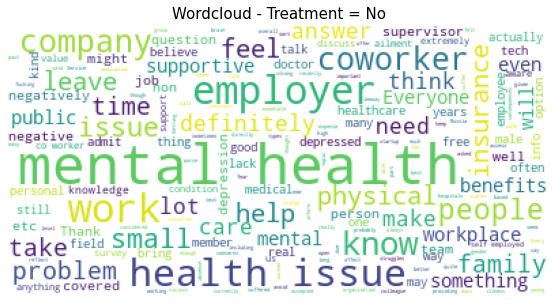

In [28]:
plt.rcParams["figure.figsize"] = (20,5)
text = df[df['treatment']=='No']['comments'].dropna().values 
wordcloud = WordCloud(background_color="white").generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Wordcloud - Treatment = No', fontsize=15)
plt.show()

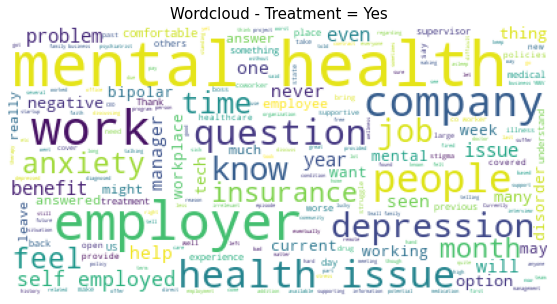

In [29]:
plt.rcParams["figure.figsize"] = (20,5)
text = df[df['treatment']=='Yes']['comments'].dropna().values 
wordcloud = WordCloud(background_color="white").generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Wordcloud - Treatment = Yes', fontsize=15)
plt.show()

# Machine Learning

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
# Importando os módulos de cálculo de métricas
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score

from sklearn.metrics import balanced_accuracy_score

In [152]:
def run_model(model, model_params, 
              model_algorithm_name):
    '''
    Essa função lê os dados e faz o processamento dos dados
    através da função pipeline do Sk Learn para tratamento
    de váriaveis faltantes. Posteriormente, é utilizado o 
    GridSearchCV para otimização dos parâmetros dos modelos.
    
    Argumentos:
      model: modelo do SK learn.
      model_params: parâmetros a serem buscados.
      model_algorithm_name: nome do algoritmo.
    
    Retorna:
      Um dataframe com os resultados e métricas dos modelos
      construídos.
    '''
    
    # Leitura e separação dos dados
    df = read_data()
    df = process_data(df)
    df = df.drop(["Timestamp", "comments", "Region Number", "Functional Programs Rate"], axis=1)

    cols = pd.DataFrame(df.dtypes.rename('type')).reset_index().rename(columns={'index': 'col'})
    categorical_features = cols[(cols['type']=='object') & (cols['col']!='treatment')]['col'].tolist()
    numerical_features = cols[cols['type']=='float64']['col'].tolist()

    X = df.drop('treatment', axis = 1)
    y = df["treatment"]
    
    # Definição dos pipelines
    numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
    ])

    categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value="Didn't answer")),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

    preprocessor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
    ])
    scorers = ['precision_macro', 'recall_macro', 'accuracy', 'roc_auc']
    score = 'recall_macro'
    
    # Construção dos algoritmos com Grid Search CV
    model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classiffier', model)])
    model_grid_search = GridSearchCV(model_pipe, param_grid=model_params, 
                                     cv=5, scoring = scorers, refit = score)
    model_grid_search.fit(X, y)
    df_results = pd.DataFrame(model_grid_search.cv_results_)\
    .sort_values(by='rank_test_recall_macro').head()\
    [['params', 'mean_test_recall_macro', 'mean_test_precision_macro', 
    'mean_test_accuracy', 'mean_test_roc_auc']]
    df_results['model'] = model_algorithm_name
    df_results = df_results.reset_index(drop=True)
    
    # Remove o classifier do nome do parâmetro
    params = df_results['params'].tolist()
    keys = list(params[0].keys())
    for d in params:
        for key in keys:
            d[key.split('__')[1]] = d.pop(key)
    df_results['params'] = params 
 
    return df_results, model_grid_search.best_estimator_

In [153]:
# Logistic Regression
model = LogisticRegression()
model_params =  dict(
                classiffier__solver = ['liblinear', 'saga'],
                classiffier__penalty =  ['l1','l2']
                )
df_results_lr, best_lr_model = run_model(model, model_params, 'Logistic Regression')

,params,mean_test_recall_macro,mean_test_precision_macro,mean_test_accuracy,mean_test_roc_auc,model
0,"{'penalty': 'l2', 'solver': 'liblinear'}",0.824504,0.830694,0.825229,0.887268,Logistic Regression
1,"{'penalty': 'l2', 'solver': 'saga'}",0.824504,0.830694,0.825229,0.887256,Logistic Regression
2,"{'penalty': 'l1', 'solver': 'liblinear'}",0.822796,0.830206,0.823626,0.891218,Logistic Regression
3,"{'penalty': 'l1', 'solver': 'saga'}",0.822796,0.830206,0.823626,0.891294,Logistic Regression


In [154]:
# Decision tree 
model = DecisionTreeClassifier()
model_params =    dict(
                  classiffier__criterion = ['gini', 'entropy'],
                  classiffier__max_depth = [4,5,6,7,8],
                  classiffier__max_features = ['auto', 'sqrt', 'log2']
                  )
df_results_dt, best_dt_model = run_model(model, model_params, 'Decision Tree')

,params,mean_test_recall_macro,mean_test_precision_macro,mean_test_accuracy,mean_test_roc_auc,model
0,"{'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt'}",0.762358,0.765709,0.762439,0.788660,Decision Tree
1,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto'}",0.760999,0.766297,0.761658,0.800783,Decision Tree
2,"{'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt'}",0.755303,0.758325,0.755378,0.803917,Decision Tree
3,"{'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto'}",0.734016,0.735555,0.733906,0.774546,Decision Tree
4,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt'}",0.733965,0.738241,0.733899,0.767872,Decision Tree


In [155]:
# Random forest
model = RandomForestClassifier()
model_params =  dict(
                  classiffier__criterion = ['gini', 'entropy'],
                  classiffier__n_estimators = [10, 50, 100],
                  classiffier__max_depth = [2,4,6,8,10],
                  classiffier__max_features = ['auto', 'sqrt', 'log2']
                  )
df_results_rf, best_rf_model = run_model(model, model_params, 'Random Forest')

,params,mean_test_recall_macro,mean_test_precision_macro,mean_test_accuracy,mean_test_roc_auc,model
0,"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}",0.827679,0.833179,0.828404,0.894743,Random Forest
1,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 100}",0.826142,0.831555,0.826817,0.893837,Random Forest
2,"{'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 100}",0.823811,0.829679,0.824436,0.891233,Random Forest
3,"{'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 100}",0.823012,0.827164,0.823636,0.891706,Random Forest
4,"{'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 100}",0.822268,0.826045,0.822842,0.892993,Random Forest
